In [7]:
from sys import argv
from os.path import exists
import json
import pysal
import numpy as np
import math
import clusterpy as cp
import csv
import sklearn.decomposition as sc
from sklearn.feature_selection import SelectKBest

In [13]:
location_dict = {}

with open("instagram_food.json") as f:
    for l in f:
        d = json.loads(l)
        key = d["coordinate"]["lat"]+"|"+d["coordinate"]["lng"]
        if key not in location_dict:
            location_dict[key] = []
        for i in d["food"]:
            location_dict[key].append(i)

In [14]:
location_dict

{u'52.38644|4.86806': [u'mussels', u'seafood', u'mussels'],
 u'52.3711027506|4.89363902557': [u'bread',
  u'bacon',
  u'onion',
  u'cheese',
  u'duck',
  u'veal',
  u'bitterballen',
  u'mustard'],
 u'51.92105|4.47222': [u'latte'],
 u'52.3097287016|4.76504071167': [u'coffee'],
 u'52.35177|4.89441': [u'hummus',
  u'vegetarian',
  u'hummus',
  u'hummus',
  u'beef',
  u'stew',
  u'hummus',
  u'hummus',
  u'hummus',
  u'hummus',
  u'sauce',
  u'hummus',
  u'avocado',
  u'tahini',
  u'wasabi',
  u'hummus',
  u'pita',
  u'hummus',
  u'vegetables',
  u'pita',
  u'beef',
  u'egg',
  u'hummus',
  u'beef',
  u'hummus',
  u'beans',
  u'vegetarian',
  u'hummus',
  u'salmon',
  u'hummus',
  u'hummus',
  u'hummus',
  u'hummus',
  u'hummus'],
 u'52.3698372584|4.87876324766': [u'garlic', u'goat', u'cheese'],
 u'52.3554775383|4.89278451167': [u'fish', u'curry', u'yellow curry'],
 u'52.3540995|4.871744': [u'pastry'],
 u'52.36951|4.89072': [u'apple',
  u'bacon',
  u'beef',
  u'stew',
  u'cabbage',
  u'pot

In [15]:
len(location_dict)

1270

In [45]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

kms_per_radian = 6371.0088
output = "food|lat|lon\n"

file = open("temp.csv","w")

with open("instagram_food.json") as f:
    for l in f:
        d = json.loads(l)
        for i in d["food"]:
            output = output + i +"|"+d["coordinate"]["lat"]+"|"+d["coordinate"]["lng"]+"\n"

file.write(output)


In [129]:
df = pd.read_csv('temp.csv', encoding='utf-8', sep="|")
df.head()
# remove duplicate
df = df.drop_duplicates(subset=['food', 'lat', 'lon'], keep=False)
# filter longitude latitude
# 4.73,52.29,4.98,52.42 bounding box of amsterdam
df = df[(df.lat >= 52.29) & (df.lat <= 52.42) & (df.lon >= 4.73) & (df.lon <= 4.98)]

In [130]:
df.head()

,food,lat,lon
0,salmon,52.369788,4.889047
4,bacon,52.375765,4.891277
5,lemon,52.375765,4.891277
6,mayonnaise,52.375765,4.891277
7,salad,52.375765,4.891277


In [203]:
# filters food!
term = "chocolate"
df_f = df[df['food'].str.contains(term)]

# represent points consistently as (lat, lon)
coords = df_f.as_matrix(columns=['lat', 'lon'])

# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 0.2 / kms_per_radian
#epsilon = 0.00005

start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df_f), num_clusters, 100*(1 - float(num_clusters) / len(df_f)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))


Clustered 119 points down to 7 clusters, for 94.1% compression in 0.01 seconds
Silhouette coefficient: -0.111


In [204]:
db.labels_

array([ 5,  1,  1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  2,  3, -1,  4, -1, -1, -1, -1,  5,  5,  4, -1,
       -1, -1,  4, -1, -1,  1, -1,  4,  2, -1,  0, -1,  3, -1,  3,  3,  3,
        3,  3, -1,  2,  2, -1, -1,  0,  0, -1,  0,  3,  3,  0, -1, -1,  2,
       -1,  5, -1,  2, -1, -1,  3,  1, -1, -1,  3, -1, -1, -1,  3,  3,  3,
        3,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  4,  0,
       -1, -1, -1,  2,  3,  3,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3])

In [205]:
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
clusters.iloc[:-1]

0    [[52.3671599586, 4.892933269], [52.36694, 4.89...
1    [[52.3663384325, 4.89821061696], [52.366338432...
2    [[52.3755627095, 4.89848607692], [52.374050127...
3    [[52.3745213825, 4.8893770055], [52.3727, 4.89...
4    [[52.3558917304, 4.89506251481], [52.3554303, ...
5    [[52.3548241, 4.8889689], [52.3574028785, 4.88...
dtype: object

In [206]:
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
clusters = clusters[:-1]
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()


,lat,lon
1,52.364941,4.898080
2,52.375029,4.897953
3,52.373830,4.888570
4,52.354574,4.893532
5,52.355789,4.890147


In [207]:
rs = rep_points.apply(lambda row: df_f[(df_f['lat']==row['lat']) & (df_f['lon']==row['lon'])].iloc[0], axis=1)
rs.to_csv('temp2.csv', encoding='utf-8')
rs.tail()


,food,lat,lon
1,chocolate,52.364941,4.898080
2,chocolate,52.375029,4.897953
3,chocolate,52.373830,4.888570
4,chocolate,52.354574,4.893532
5,chocolate cake,52.355789,4.890147


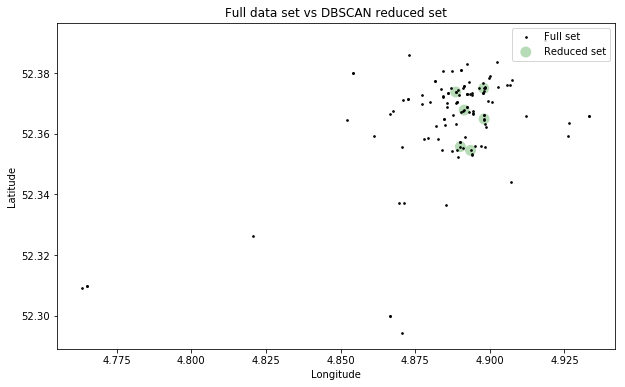

In [208]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df_f['lon'], df_f['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
